In [3]:
class Hit:
    "represents a waveform with a fixed number of voltage values over time"
    def __init__(self, fname=None, waveform=None):
        self.file_name = fname
        self.start_time = None
        self.waveform = waveform
        self.entropy = None
        self.ie_outlier = None
        self.sample_interval = None
        self.spectrogram = None
    
    def ID(self):
        return self.file_name.split("\\")[-1].split(".")[0]
    def write_wave(self, folder):
        if not folder[-1] == "\\":
            folder = folder + "\\"
        f =  folder + self.ID()
        np.save(f,self.waveform)
    
    def write_spect(self, folder):
        if not folder[-1] == "\\":
            folder = folder + "\\"
        f =  folder + self.ID()
        np.save(f,self.spectrogram)
    

    def read_text(self, fname=None):
        if fname is not None:
            self.file_name = fname
        with open(self.file_name, mode='r') as f:
            txt = f.readlines()
        for ind, line in enumerate(txt):
            if "TIME OF TEST:" in line:
                self.start_time = float(line.split(": ")[1])
            if "SAMPLE INTERVAL (Seconds):" in line:
                self.sample_interval = float(line.split(": ")[1])
            if line=="\n":
                self.waveform = []
                break
        else:
            print(fname)
            raise ValueError("Expected blank line not found in waveform datafile")
        for line in txt[ind+1:]:
            self.waveform.append(float(line))
    def spect(self, binsize, sample_rate=1, plot=False):
        pass

class MetaTable:
    def __init__(self, fname):
        import csv
        self.fname = fname
        with open(self.fname, mode='r') as f:
            abc = []
            read = csv.reader(f)
            for row in read:
                abc.append(row)
        self.contents =abc
    def get_hits(f):
        pass

#a = MetaTable("metadata.csv")

### Setup

##### Imports

In [4]:
import os
import numpy as np
import time
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, models
import umap
import matplotlib as mpl

##### Load Data

3.3188894118315133 3.821388965029227


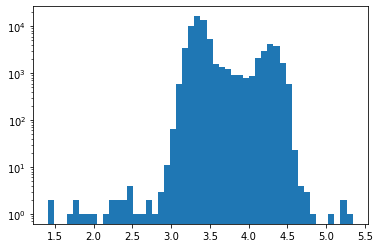

In [5]:
specs = np.load("spectrograms.npy")
entropy = np.load("entropy.npy")
import matplotlib.pyplot as plt

th = 2*np.quantile(entropy, .75) - np.quantile(entropy, .25)
print(np.quantile(entropy, .25), np.quantile(entropy, .75))
fig = plt.hist(entropy, bins=50, log='y')

##### Test/Train Split

In [88]:
np.random.seed(42)
filt = np.random.rand(len(specs))
raw_train = []; raw_val = []
for i in range(len(specs)):
    if filt[i]<0.8:
        raw_train.append(specs[i])
    else:
        raw_val.append(specs[i])
raw_train = np.array(raw_train)
raw_val = np.array(raw_val)

##### Adjust Pixel Values

Text(0.5, 0, 'Spectrogram Pixel Intensity')

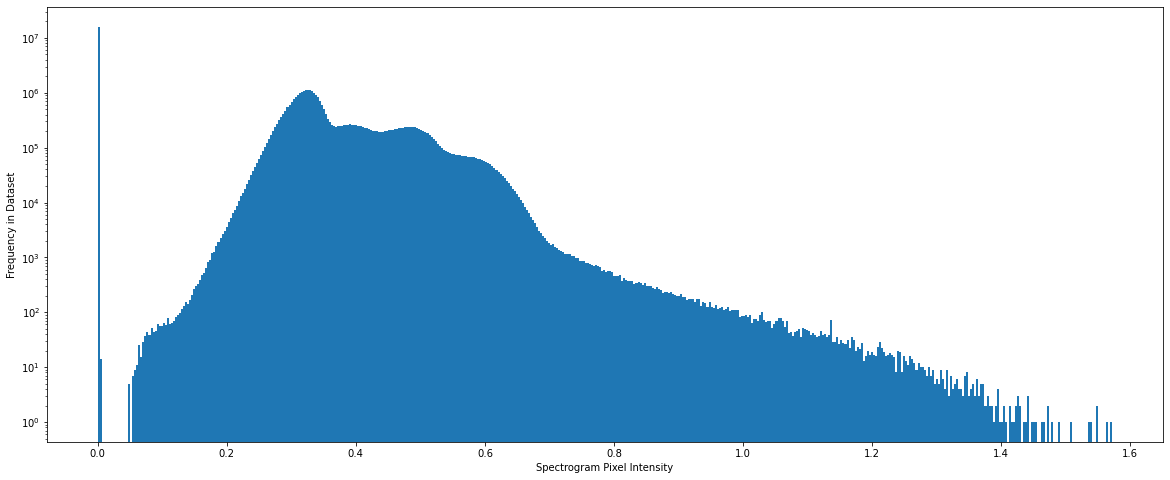

In [89]:
def root(dset, num): # function to take even root as specified (sqrt, 4th, 6th, etc roots)
    return dset if num<=0 else root(np.sqrt(dset),num-1)
r = 4

sp_train = root(raw_train,r)
sp_val = root(raw_val, r)

# Pixel intensity distribution
plt.figure(101, figsize=(20,8))
h=plt.hist(np.concatenate(np.concatenate(sp_val)), bins=500, log=0)
plt.ylabel("Frequency in Dataset")
_ = plt.xlabel("Spectrogram Pixel Intensity")

### Building an Autoencoder Model

In [7]:
class Autoencoder(models.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()   # initialize tensorflow model
        self.encoder = tf.keras.Sequential([  # convolutional model which reduces image down to 50 points
            layers.Input(shape=(61, 58, 1)),
            layers.Conv2D(32, 3, activation='relu'),
            layers.Conv2D(16, 3, activation='relu'),
            layers.Flatten(),
            layers.Dense(50)
            ])
        self.decoder = tf.keras.Sequential([  # inverse convolutional model which regenerates original image
            layers.Input(shape=(50)),
            layers.Dense(49248, activation='relu'),
            layers.Reshape((57, 54, 16)),
            #layers.Input(shape=(57, 54, 16)),
            layers.Conv2DTranspose(16, 3, activation='relu'),
            layers.Conv2DTranspose(16, 3, activation='relu'), 
            layers.Conv2DTranspose(8, 3, activation='relu'),
            layers.Conv2D(1, 3, activation='relu')
            ])

    def call(self, x):            # ensure model calls both encoder and decoder during training
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

automod = Autoencoder()
automod.encoder.summary()
automod.decoder.summary()
automod.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError())

checkpoint_path = "cp{epoch}.ckpt"
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1)

def enc(vals): # encode an spectrogram into the latent space and then decode it 
    encoded_space = []
    decoded_space = []
    for i in range(0,len(vals), 100):
        j = min(len(vals), i+100)
        print(i, end=" ")
        #time.sleep(0.3)
        encoded_space.append(automod.encoder(vals[i:j,:,:]))
        decoded_space.append(automod.decoder(encoded_space[-1]))

    return np.concatenate(encoded_space), np.concatenate(decoded_space)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 59, 56, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 54, 16)        4624      
                                                                 
 flatten (Flatten)           (None, 49248)             0         
                                                                 
 dense (Dense)               (None, 50)                2462450   
                                                                 
Total params: 2,467,394
Trainable params: 2,467,394
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)        

### Training the Autoencoder

Epoch 1/3
1811/1811 [==============================] - ETA: 0s - loss: 0.0079
Epoch 1: saving model to cp1.ckpt
1811/1811 [==============================] - 132s 70ms/step - loss: 0.0079 - val_loss: 6.4555e-04
Epoch 2/3
1811/1811 [==============================] - ETA: 0s - loss: 6.4150e-04
Epoch 2: saving model to cp2.ckpt
1811/1811 [==============================] - 68s 37ms/step - loss: 6.4150e-04 - val_loss: 6.3246e-04
Epoch 3/3
1810/1811 [============================>.] - ETA: 0s - loss: 6.9848e-04
Epoch 3: saving model to cp3.ckpt
1811/1811 [==============================] - 71s 39ms/step - loss: 6.9847e-04 - val_loss: 6.4356e-04


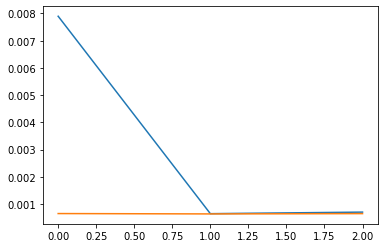

In [8]:
weight_file = None

if weight_file is None:         # train model and plot progress
    autohist = automod.fit(x=sp_train, y=sp_train, epochs=3, validation_data=(sp_val, sp_val), callbacks=cp_callback)
    plt.plot(autohist.history['loss'], label='loss')
    plt.plot(autohist.history['val_loss'], label = 'val_loss')
    plt.show()
else:                           # load model from file
    automod.load_weights(weight_file)

In [9]:
(a, b) = enc(np.array(sp_val))
print(sp_val.shape)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 (14378, 61, 58)


In [10]:
IDs = np.load("IDs.npy")
ida = IDs[filt>0.8]
enta = entropy[filt>0.8]

tst = []; pt = []
for i in ida:
    tst.append(int(i.split("_")[0][-1]))
    pt.append(int(i.split(".")[0].split("_")[-1]))
    
reducer = umap.UMAP()
latent = a
flat = reducer.fit_transform(latent)

[488, 12188, 35962, 14212]
[0.0204918  0.21516393 0.22336066 ... 0.06937799 0.06972981 0.07015198] 4
Z len&max: 14378 4.687489998898571
(14378, 2)


C:\Users\david\AppData\Local\Temp\ipykernel_4484\3104859021.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


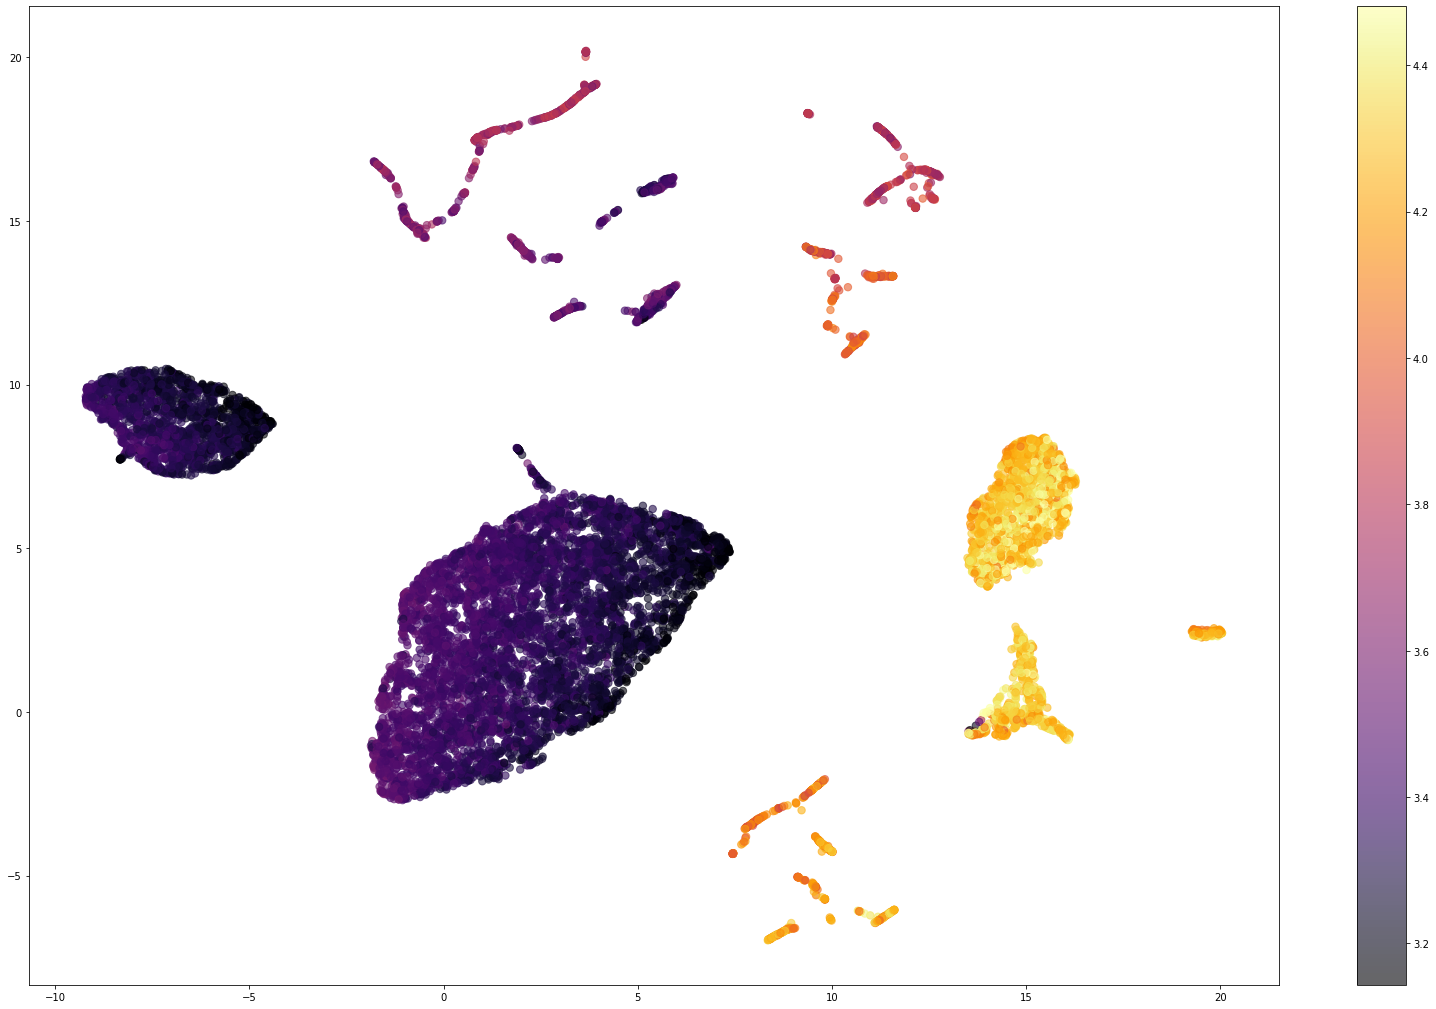

In [72]:
tst =np.array(tst)
pt=np.array(pt)
p1 = [max(pt[tst==i+1]) for i in range(4)]
pt2 = np.array([pt[i]/p1[tst[i]-1] for i in range(len(pt))])
print(p1)
print(pt2, len(p1))

# ********** Plot 1 ***********
z = enta
zlim = [np.quantile(z,.01), np.quantile(z,.99)]
print("Z len&max:", len(z), max(z))
print(flat.shape)
cmap = mpl.cm.inferno
s = np.random.rand(tst.shape[0])
f0 = [x for _, x in sorted(zip(s, flat[:,0]))]
f1 = [x for _, x in sorted(zip(s, flat[:,1]))]
z2 = [x for _, x in sorted(zip(s, z))]

fig1 = plt.figure(100, figsize=(28,18))
scatterplot = plt.scatter(f0, f1, s=55, c=z2, cmap=cmap, vmin=zlim[0], vmax=zlim[1], alpha=0.6)
plt.colorbar()
fig1.show()

Z len&max: 14378 4
(14378, 2)


C:\Users\david\AppData\Local\Temp\ipykernel_4484\818662044.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


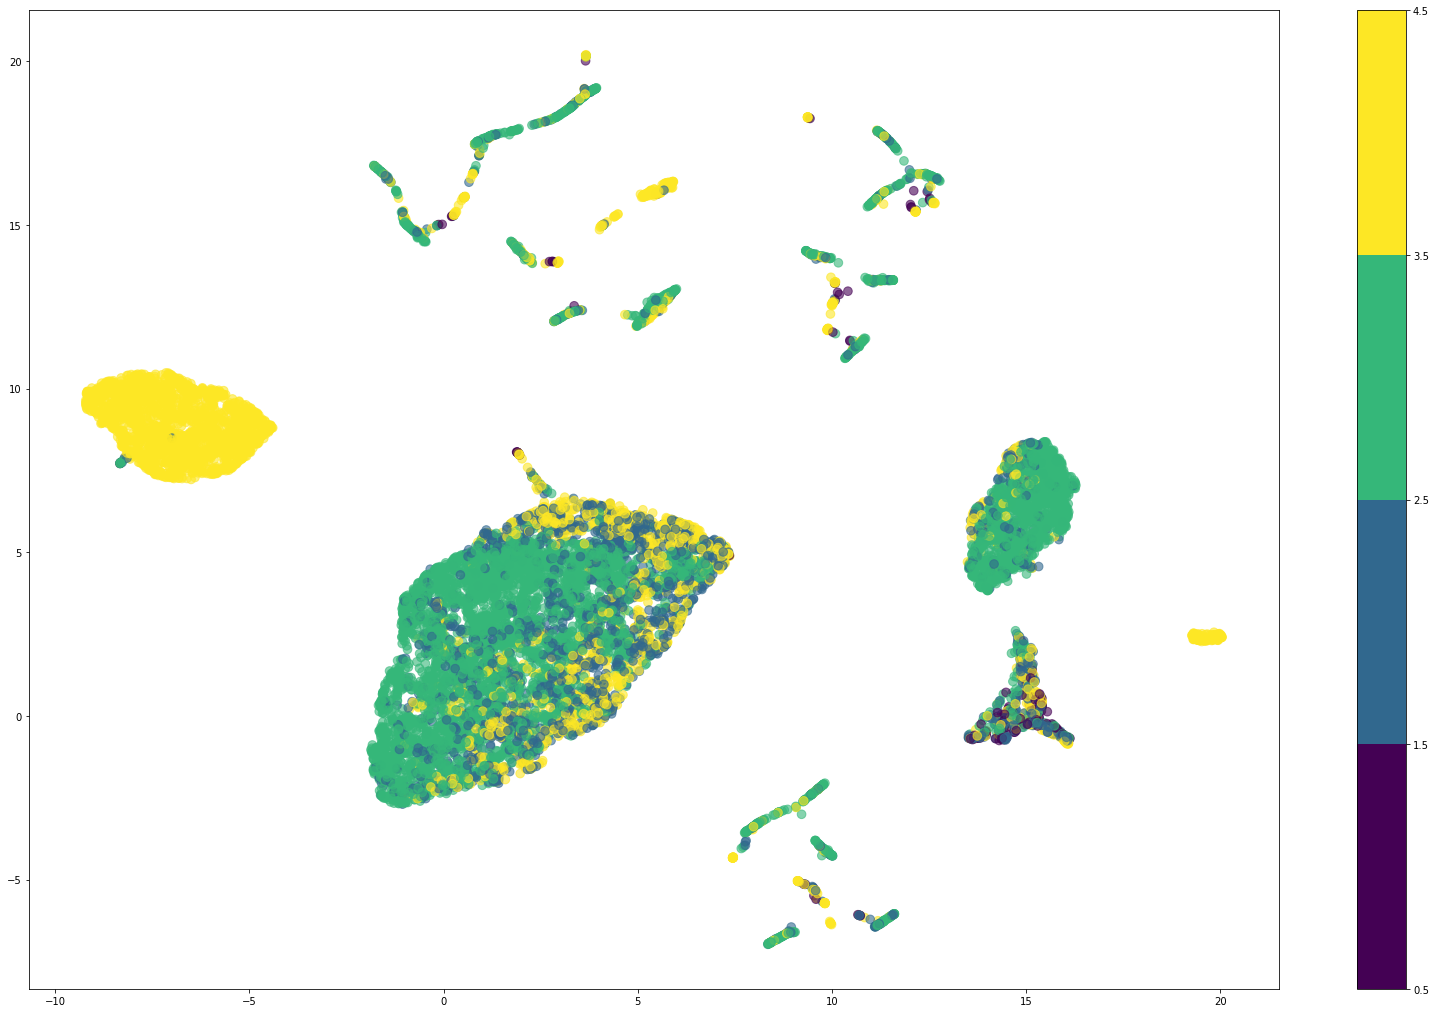

In [84]:
# *********** Plot 2 ***********
z = tst
zlim = [np.quantile(z,.01), np.quantile(z,.99)]
print("Z len&max:", len(z), max(z))
print(flat.shape)
cmap = mpl.cm.viridis
norm = mpl.colors.BoundaryNorm(np.arange(5)+0.5, cmap.N)
s = np.random.rand(tst.shape[0])
f0 = [x for _, x in sorted(zip(s, flat[:,0]))]
f1 = [x for _, x in sorted(zip(s, flat[:,1]))]
z2 = [x for _, x in sorted(zip(s, z))]

fig2 = plt.figure(100, figsize=(28,18))
ax2 = plt.axes()
scatterplot = plt.scatter(f0, f1, s=75, c=z2, cmap=cmap, norm=norm, alpha=0.6) # vmin=zlim[0], vmax=zlim[1])
fig2.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm))

fig2.show()

median 0.31680168775927514
0.610452032175063
99 %ile: 0.6100972703145453
Original Maximum: 1.5723894390955084 1.6190895015404048
Recoded Maximum: 6.2235518
0.6100972703145453
4.009 4.005 4.003 4.004 4.001 4.006 4.009 4.001 4.006 4.008 

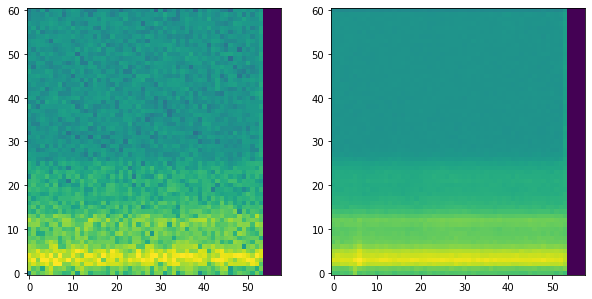

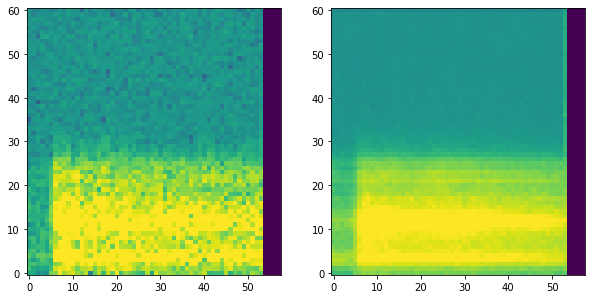

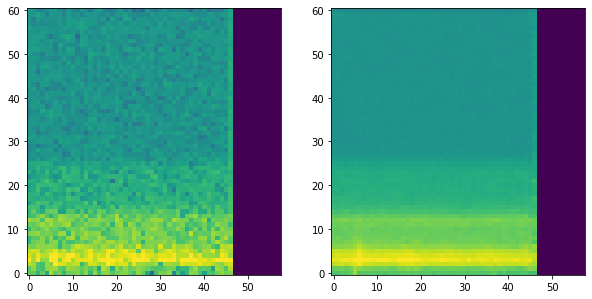

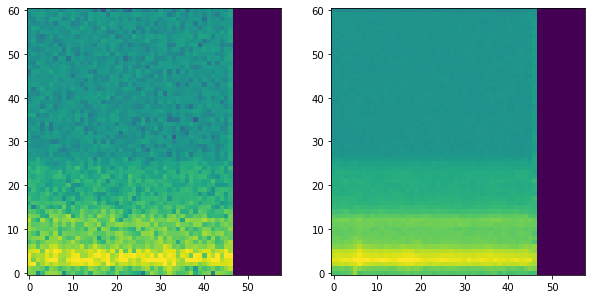

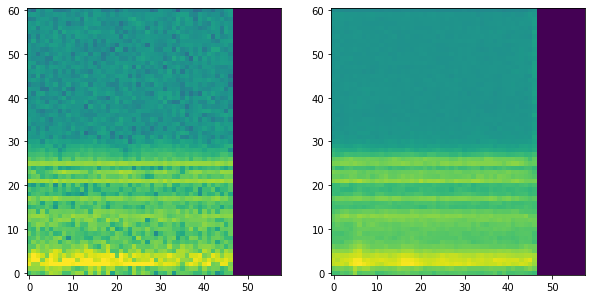

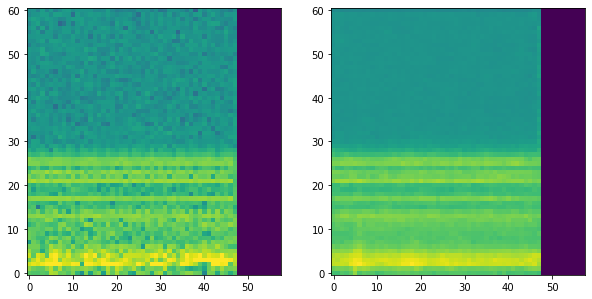

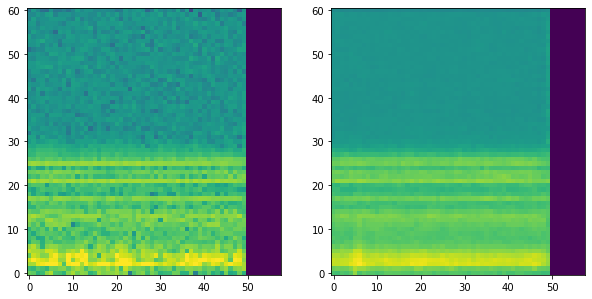

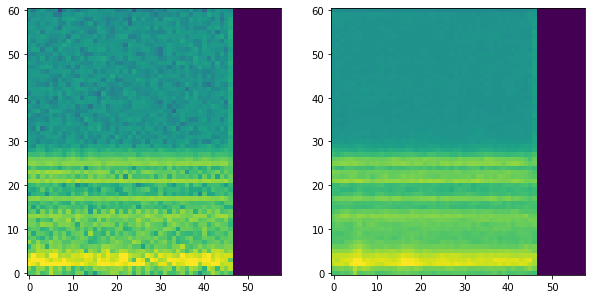

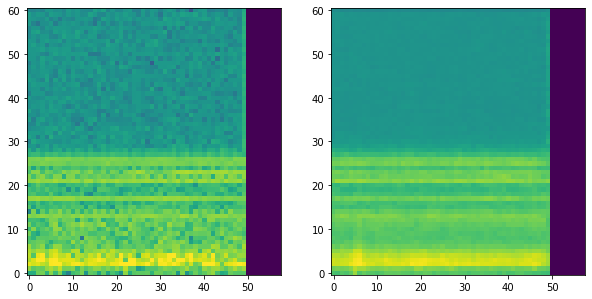

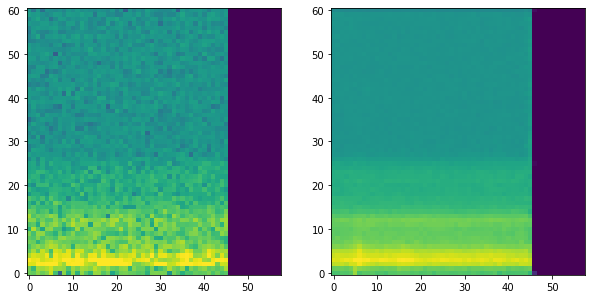

In [13]:
mx = np.quantile(sp_val, 0.99)
print("median", np.median(sp_val))
print(np.quantile(sp_train, 0.99))
print("99 %ile:", mx)
print("Original Maximum:", np.max(sp_val), np.max(sp_train))
print("Recoded Maximum:", np.max(a))
print(mx)
for i in range(0, len(b), 1):
    if 4<enta[i]<4.01:
        print(f"{enta[i]:.3f}", end=" ")
        fig, ax = plt.subplots(1,2, figsize=(10,10))
        #print(f"**{tst[i]}**")
        ax[0].imshow(sp_val[i], origin="lower", vmin=0, vmax=mx)
        ax[1].imshow(b[i], origin="lower", vmin=0, vmax=mx)
plt.show()